# DSCI 591: Data Science Capstone I <br> EDA on FLAME 1 Dataset

## Project Objective

1. Build model to detect the presence of forest fires
2. Build model to detect border / boundary of forest fire

## Primary Use Case

Park rangers pilot drones to at-risk locations for surveillance and early fire detection. Data is relayed as input for the model.

## Description of Data

1. **Primary Use:** Primary Modeling Dataset
2. **Summary:** Contains raw video and processed images from a controlled burn in an Arizon pine forest. Specifically, there are video recordings and thermal heatmaps (infrared cameras).
3. **Link:** https://paperswithcode.com/dataset/flame

## List of Files within Dataset

1. Raw Video (All)
        a. File Type: MP4
        b. Description: 966s footage from Zenmuse X4S camera
2. Raw Video (Specific Burn Patch)
        a. File Type: MP4
        b. Description: 400s footage from Zenmuse X4S camera
3. Raw Video (thermal - White Hot)
        a. File Type: MOV
        b. Description: 89s footage from FLIR Vue Pro R thermal camera     
4. Raw Video (thermal - Green Hot)
        a. File Type: MOV
        b. Description: 305s from FLIR Vue Pro R thermal camera
5. Raw Video (thermal fusion)
        a. File Type: MOV
        b. Description: 25-min footage from FLIR Vue Pro R thermal camera
6. Raw Video (Phantom Drone)
        a. File Type: MOV
        b. Description: 17-min footage from DJI Phantom 3 camera
7. Training / Validation Images (Classification)
        a. File Type: JPG
        b. Description: 39,375 frames, either “Fire” or “No Fire”
8. Test Images (Classification)
        a. File Type: JPG
        b. Description: 8,617 frames, either “FIre” or “No Fire”
9. Images (Segmentation)
        a. File Type: JPG
        b. Description: 2,003 frames for Train / Test / Val
10. Masks Annotation (Segmentation)
        a. File Type: JPG
        b. Description: 2,003 ground truth mask frames for Train / Test / Val

## Exploratory Data Analysis (EDA)

### Importing the Data

In [1]:
from pathlib import Path

## Set current directory
local_train_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Training"
local_test_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Test"

#Set classes to iterate through
class_data = ['No_Fire','Fire']

In [2]:
#Install OpenCV package: https://pypi.org/project/opencv-python/
!pip install opencv-python

In [3]:
import cv2
import os
import re

#Create a function to tokenize the file name strings, returning a unique id and type of file
def tokenize_file_name(label, filename_string):
    tokens = re.split("_", filename_string)
    token_of_interest = tokens[-1]
    tokenizing = re.split("\.", token_of_interest)
    file_id = tokenizing[0]
    file_type = tokenizing[-1]
    tokenizing = re.split("frame", file_id)
    file_id = label + "_" + tokenizing[-1]
    
    return file_id, file_type

#Create a function to grab the dimensions (pixels) and channels (color or b&w) of files
def get_dimensions_and_channels(file_string):
    image = cv2.imread(file_string)
    height, width, channel = image.shape
    
    return height, width, channel

In [4]:
### TRAINING DATA COLLECTION/AGGREGATION ###
train_data = []

for label in class_data:
    for item in os.listdir(os.path.join(local_train_dir, label)):
        item_name = item
        item_label = label
        item_id, item_type = tokenize_file_name(label, item)
        item_path = os.path.join(local_train_dir, label, item)
        item_height, item_width, item_channel = get_dimensions_and_channels(item_path)

        train_data.append([item_id, item_type, item_height, item_width, item_channel, item_name, item_path, item_label])

In [5]:
### TEST DATA COLLECTION/AGGREGATION ###
test_data = []

for label in class_data:
    for item in os.listdir(os.path.join(local_test_dir, label)):
        item_name = item
        item_label = label
        item_id, item_type = tokenize_file_name(label, item)
        item_path = os.path.join(local_test_dir, label, item)
        item_height, item_width, item_channel = get_dimensions_and_channels(item_path)

        test_data.append([item_id, item_type, item_height, item_width, item_channel, item_name, item_path, item_label])

In [6]:
import pandas as pd

### TRAINING DATAFRAME CREATION ###
train_df = pd.DataFrame(train_data, columns=['id', 'file_type', 'pixel_height', 'pixel_width', 
                                       'image_channels', 'file_name', 'file_path', 'label'])

### Examine Training dataframe head ###
train_df.head(5)

,id,file_type,pixel_height,pixel_width,image_channels,file_name,file_path,label
0,No_Fire_0,jpg,254,254,3,lake_resized_lake_frame0.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
1,No_Fire_1,jpg,254,254,3,lake_resized_lake_frame1.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
2,No_Fire_10,jpg,254,254,3,lake_resized_lake_frame10.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
3,No_Fire_100,jpg,254,254,3,lake_resized_lake_frame100.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
4,No_Fire_1000,jpg,254,254,3,lake_resized_lake_frame1000.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire


In [7]:
### TEST DATAFRAME CREATION ###
test_df = pd.DataFrame(test_data, columns=['id', 'file_type', 'pixel_height', 'pixel_width', 
                                       'image_channels', 'file_name', 'file_path', 'label'])

### Examine Training dataframe head ###
test_df.head(5)

,id,file_type,pixel_height,pixel_width,image_channels,file_name,file_path,label
0,No_Fire_0,jpg,254,254,3,resized_test_nofire_frame0.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
1,No_Fire_1,jpg,254,254,3,resized_test_nofire_frame1.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
2,No_Fire_10,jpg,254,254,3,resized_test_nofire_frame10.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
3,No_Fire_100,jpg,254,254,3,resized_test_nofire_frame100.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
4,No_Fire_1000,jpg,254,254,3,resized_test_nofire_frame1000.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire


### View Sampling of Images

In [20]:
## Create a function to show specific images
from IPython.display import Image

def show_image(file_string):
    display(Image(filename=file_string))

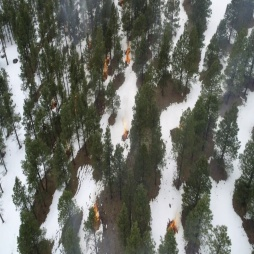

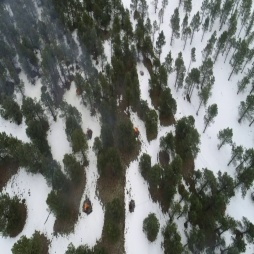

In [25]:
## Explore TRUE labels in Train dataset
train_fire_subset = train_df[train_df.label == "Fire"]

nofire_sample_1 = show_image(train_fire_subset.iloc[1000]["file_path"])
nofire_sample_2 = show_image(train_fire_subset.iloc[10000]["file_path"])

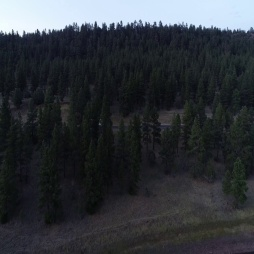

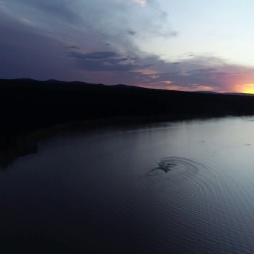

In [24]:
## Explore FALSE Labels in Train dataset
train_no_fire_subset = train_df[train_df.label == "No_Fire"]

nofire_sample_1 = show_image(train_no_fire_subset.iloc[1000]["file_path"])
nofire_sample_2 = show_image(train_no_fire_subset.iloc[10000]["file_path"])

### Examine Image Sizing (Graphically)

In [34]:
## TRAINING: Check height, width, and channels
print("TRAINING DATASET Unique Values:")
print("Pixel Height:", train_df["pixel_height"].unique())
print("Pixel Width:", train_df["pixel_width"].unique())
print("Image Channels:", train_df["image_channels"].unique())
print()

## TEST: Check height, width, and channels
print("TEST DATASET Unique Values:")
print("Pixel Height:", test_df["pixel_height"].unique())
print("Pixel Width:", test_df["pixel_width"].unique())
print("Image Channels:", test_df["image_channels"].unique())

TRAINING DATASET Unique Values:
Pixel Height: [254]
Pixel Width: [254]
Image Channels: [3]

TEST DATASET Unique Values:
Pixel Height: [254]
Pixel Width: [254]
Image Channels: [3]


In [37]:
!pip install hvplot

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.3.2
    Uninstalling bokeh-2.3.2:
      Successfully uninstalled bokeh-2.3.2


In [47]:
import hvplot.pandas

## TRAINING: Graphing height against width
sizes = train_df.groupby(['pixel_height', 'pixel_width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='pixel_height', y='pixel_width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(line_alpha=1, fill_alpha=0.3)

:Scatter   [pixel_height]   (pixel_width,count)

In [90]:
## TEST: Graphing height against width
sizes = test_df.groupby(['pixel_height', 'pixel_width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='pixel_height', y='pixel_width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(line_alpha=1, fill_alpha=0.3)

:Scatter   [pixel_height]   (pixel_width,count)

### Examine Image Label Distribution

In [49]:
#TRAIN: Examine label values
train_df["label"].value_counts()

Fire       25018
No_Fire    14357
Name: label, dtype: int64

In [50]:
#TEST: Examine label values
test_df["label"].value_counts()

Fire       5137
No_Fire    3480
Name: label, dtype: int64

<AxesSubplot:title={'center':'Test Dataset: Label Counts'}, xlabel='Label', ylabel='Count'>

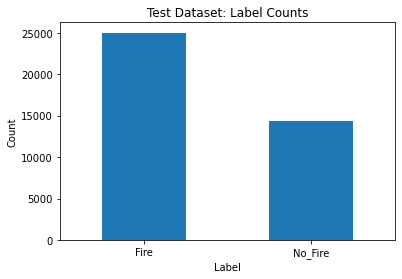

In [72]:
#TRAIN: Explore labels graphically
import matplotlib.pyplot as plt

train_df["label"].value_counts().plot(kind='bar', xlabel = "Label", ylabel = "Count", 
                                      rot=0, title = "Test Dataset: Label Counts")

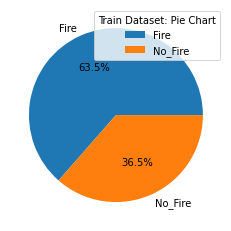

In [87]:
plt.pie(train_df["label"].value_counts(), labels = ["Fire", "No_Fire"], autopct='%1.1f%%')
plt.legend(title = "Train Dataset: Pie Chart")
plt.show() 

<AxesSubplot:title={'center':'Test Dataset: Label Counts'}, xlabel='Label', ylabel='Count'>

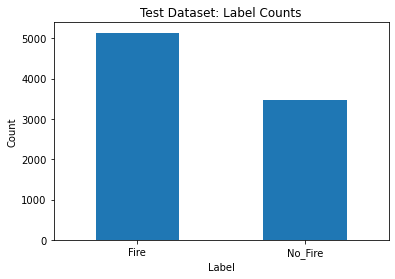

In [88]:
#TEST: Explore labels graphically
test_df["label"].value_counts().plot(kind='bar', xlabel = "Label", ylabel = "Count", 
                                      rot=0, title = "Test Dataset: Label Counts")

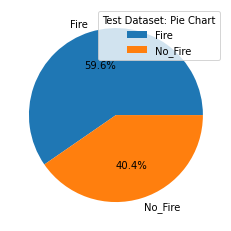

In [89]:
plt.pie(test_df["label"].value_counts(), labels = ["Fire", "No_Fire"], autopct='%1.1f%%')
plt.legend(title = "Test Dataset: Pie Chart")
plt.show() 

### Examine Pixel Data (RGB channels) by label

In [8]:
## Hypothesis - truth labels will be more red channel

### Compute "Mean Image"

In [9]:
## Overall

In [ ]:
## By label